In [1]:
!python -m pip install --user --upgrade pip
!pip install --user keras
!pip install --user tensorflow
!pip install --user -U numpy

distributed 1.21.8 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 19.2.2 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=6594 sha256=3c932177b0bf404e972bc5735ee88f692b9d173db863523ee15c24e29043d44d
  Stored in directory: C:\Users\mayingzh\AppData\Local\pip\Cache\wheels\5c\2e\7e\a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
  Created wheel for absl-py: filename=absl_py-0.7.1-cp36-none-any.whl size=113722 sha256=031796e87f77632c407ad9ae0207e44808126f90d2938207997e906faae5439c
  Stored in directory: C:\Users\mayingzh\AppData\Local\pip\Cache\wheels\ee\98\38\46cbcc5a93cfea5492d19c38562691ddb23b940176c14f7b48
  Created wheel for wrapt: filename=wrapt-1.11.2-cp36-none-any.whl size=18733 sha256=0b418002710569e77f1038baee964f35ce8c3d13d4d898569fd7191c4fc0ca3f
  Stored in directory: C:\Users\mayingzh\AppData\Local\pip\Cache\wheels\d7\de\2e\efa132238792efb6459a96e85916ef8597fcb3d2ae51590dfd
  Created wheel for termcolor: filename=termcolor-1.1.0-cp36-none-any.whl size=4006 sha256=5edff00a7e505311eb14e9e7e94eeecfe6a132716ebee04ba72b5610daf8061

ERROR: tensorboard 1.14.0 has requirement setuptools>=41.0.0, but you'll have setuptools 39.1.0 which is incompatible.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


Requirement already up-to-date: numpy in c:\users\mayingzh\appdata\roaming\python\python36\site-packages (1.17.0)


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers.advanced_activations import PReLU, ELU
from keras.layers.normalization import BatchNormalization
from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasRegressor
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as skm, math
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\wangmi94\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\wangmi94\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\wangmi94\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\wangmi94\AppData\Roaming\Python\Py

## Load data and do data normalization

In [2]:
def moneyness(S,X):
    return S/X

In [3]:
def intrinsic(S, K, C, P):
    return C*(max(S-K, 0)) + P*(max(K-S, 0))

In [4]:
def load_data(file):
    df = pd.read_csv(file)
    df = df.dropna()
    
    # Remove the option data has less than 7 days to maturity.
    df = df[df.maturity > 6]
    
    df['moneyness'] = df.apply(lambda row: moneyness(row['underlying_price'], row['strike_price']), axis = 1)
    dfout = df[df.moneyness >= 0.5]
    dfin = df[df.moneyness <= 1.5]
    df = df[df.moneyness >= 0.5]
    df = df[df.moneyness <= 1.5]
    
    # Calculate the intrinsic value of at-the-money options
    df['intrinsic'] = df.apply(lambda row: intrinsic(row['underlying_price'], row['strike_price'], row['cp_flag_C'], row['cp_flag_P']), axis = 1)
    # Calculate the intrinsic value of in-the-money the options
    dfin['intrinsic'] = df.apply(lambda row: intrinsic(row['underlying_price'], row['strike_price'], row['cp_flag_C'], row['cp_flag_P']), axis = 1)
    # Calculate the intrinsic value of out-of-money the options
    dfout['intrinsic'] = df.apply(lambda row: intrinsic(row['underlying_price'], row['strike_price'], row['cp_flag_C'], row['cp_flag_P']), axis = 1)
    #at-the-money options
    sample_df = df[['strike_price', 'underlying_price', 'maturity', 'impl_volatility', 'realized_vol', 'cp_flag_C', 'cp_flag_P', 
                    'interest_rate', 'intrinsic', 'moneyness', 'best_offer']].apply(pd.to_numeric)
    sample_df = sample_df.reset_index(drop=True)
    #in-the-money options
    sample_dfin = dfin[['strike_price', 'underlying_price', 'maturity', 'impl_volatility', 'realized_vol', 'cp_flag_C', 'cp_flag_P', 
                    'interest_rate', 'intrinsic', 'moneyness', 'best_offer']].apply(pd.to_numeric)
    sample_dfin = sample_dfin.reset_index(drop=True)
    #Out-of-money options
    sample_dfout = dfout[['strike_price', 'underlying_price', 'maturity', 'impl_volatility', 'realized_vol', 'cp_flag_C', 'cp_flag_P', 
                    'interest_rate', 'intrinsic', 'moneyness', 'best_offer']].apply(pd.to_numeric)
    sample_dfout = sample_dfout.reset_index(drop=True)
    
    return sample_df,sample_dfin,sample_dfout

In [5]:
sample_df,sample_dfin,sample_dfout = load_data('Options_R_new.csv')
sample_df.head()


,strike_price,underlying_price,maturity,impl_volatility,realized_vol,cp_flag_C,cp_flag_P,interest_rate,intrinsic,moneyness,best_offer
0,50.0,58.61,18,0.365853,0.169029,1,0,0.001,8.61,1.172200,8.70
1,52.5,58.61,18,0.294871,0.169029,1,0,0.001,6.11,1.116381,6.20
2,55.0,58.61,18,0.252262,0.169029,1,0,0.001,3.61,1.065636,3.85
3,57.5,58.61,18,0.214273,0.169029,1,0,0.001,1.11,1.019304,1.74
4,60.0,58.61,18,0.194355,0.169029,1,0,0.001,0.00,0.976833,0.46


In [8]:
sample_dfin.head()


,strike_price,underlying_price,maturity,impl_volatility,realized_vol,cp_flag_C,cp_flag_P,interest_rate,intrinsic,moneyness,best_offer
0,50.0,58.61,18,0.365853,0.169029,1,0,0.001,8.61,1.172200,8.70
1,52.5,58.61,18,0.294871,0.169029,1,0,0.001,6.11,1.116381,6.20
2,55.0,58.61,18,0.252262,0.169029,1,0,0.001,3.61,1.065636,3.85
3,57.5,58.61,18,0.214273,0.169029,1,0,0.001,1.11,1.019304,1.74
4,60.0,58.61,18,0.194355,0.169029,1,0,0.001,0.00,0.976833,0.46


In [9]:
sample_dfout.head()

,strike_price,underlying_price,maturity,impl_volatility,realized_vol,cp_flag_C,cp_flag_P,interest_rate,intrinsic,moneyness,best_offer
0,50.0,58.61,18,0.365853,0.169029,1,0,0.001,8.61,1.172200,8.70
1,52.5,58.61,18,0.294871,0.169029,1,0,0.001,6.11,1.116381,6.20
2,55.0,58.61,18,0.252262,0.169029,1,0,0.001,3.61,1.065636,3.85
3,57.5,58.61,18,0.214273,0.169029,1,0,0.001,1.11,1.019304,1.74
4,60.0,58.61,18,0.194355,0.169029,1,0,0.001,0.00,0.976833,0.46


In [6]:
def get_corr(sample_df):
    corr_matrix = sample_df.corr()
    
    fig = plt.figure(figsize = (10,10))
    sns.heatmap(corr_matrix, vmax = .8, square = True)
    plt.show()
    
    corr = corr_matrix['best_offer'].sort_values(ascending=False)
    print(corr)
    
    return corr

In [10]:
sample_df.shape


(1700235, 11)

In [11]:
sample_dfin.shape


(1700477, 11)

In [12]:
sample_dfout.shape

(1866797, 11)

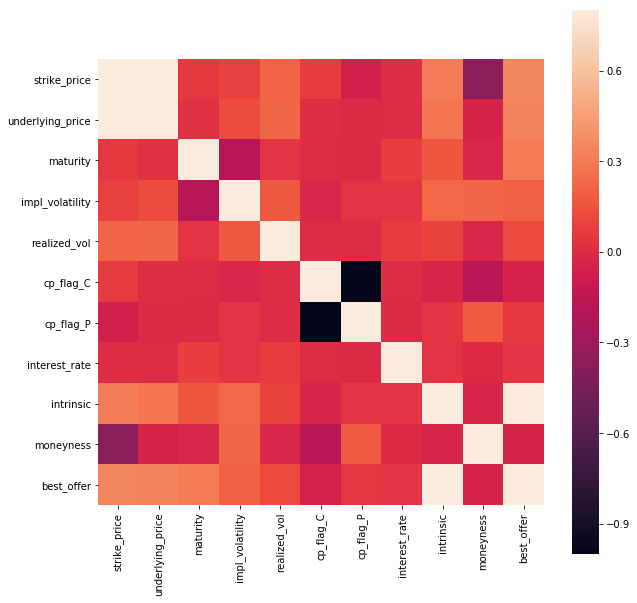

best_offer          1.000000
intrinsic           0.976694
strike_price        0.345604
underlying_price    0.332923
maturity            0.301267
impl_volatility     0.196128
realized_vol        0.118990
cp_flag_P           0.047227
interest_rate       0.038505
moneyness          -0.038097
cp_flag_C          -0.047227
Name: best_offer, dtype: float64


In [13]:
corr = get_corr(sample_df)

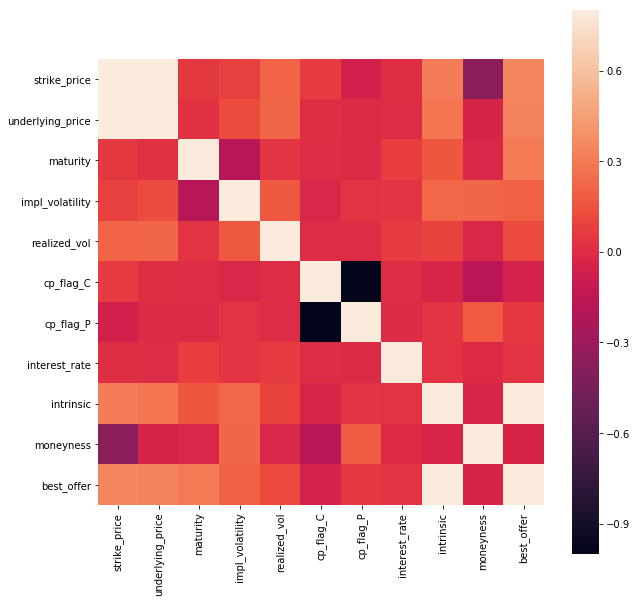

best_offer          1.000000
intrinsic           0.976694
strike_price        0.345582
underlying_price    0.332450
maturity            0.300725
impl_volatility     0.196561
realized_vol        0.119011
cp_flag_P           0.047551
interest_rate       0.038825
moneyness          -0.038887
cp_flag_C          -0.047551
Name: best_offer, dtype: float64


In [14]:
corrin = get_corr(sample_dfin)

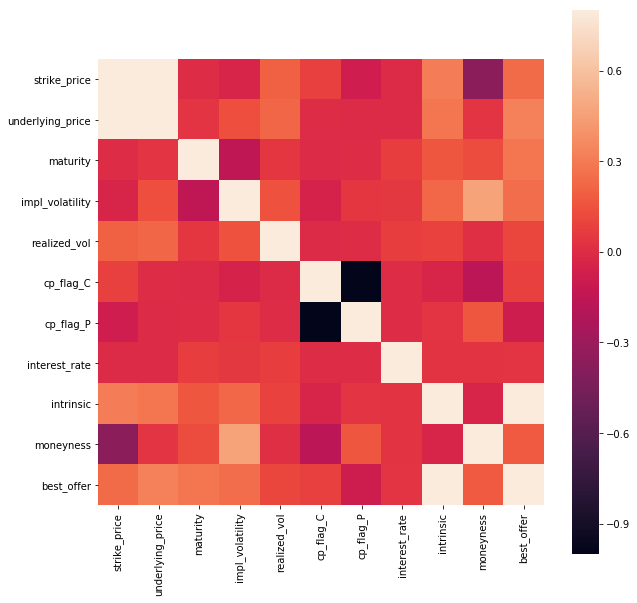

best_offer          1.000000
intrinsic           0.976694
underlying_price    0.321998
maturity            0.279719
impl_volatility     0.246615
strike_price        0.238499
moneyness           0.175498
realized_vol        0.110521
cp_flag_C           0.087387
interest_rate       0.035599
cp_flag_P          -0.087387
Name: best_offer, dtype: float64


In [15]:
corrout = get_corr(sample_dfout)

In [16]:
def data(s_df):
    
    y = s_df['best_offer'].values
    X = s_df[[ 'intrinsic', 'strike_price', 'underlying_price', 'maturity', 'impl_volatility', 'cp_flag_P', 'interest_rate',]]
    
#     sc_X = StandardScaler()
#     X_scale = sc_X.fit_transform(X)

#     sc_y = StandardScaler()
    y = y.reshape(-1,1)
#     y_scale = sc_y.fit_transform(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    return X_train, X_test, y_train, y_test

In [17]:
X_train, X_test, y_train, y_test = data(sample_df.sample(n=600000))

In [21]:
#In-the-money
X_traini, X_testi, y_traini, y_testi = data(sample_dfin.sample(n=600000))

In [22]:
#Out-of-money
X_traino, X_testo, y_traino, y_testo = data(sample_dfout.sample(n=600000))

In [18]:
y_test[:10]

array([[ 9.05],
       [ 0.06],
       [ 0.15],
       [ 0.76],
       [ 1.54],
       [ 5.2 ],
       [ 0.05],
       [ 0.17],
       [ 1.03],
       [14.5 ]])

## Build a keras Sequential model

In [19]:
# Because it is a simple regression problem, we should custom metrics function
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis = -1))

def r_square(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return (1 - SS_res/(SS_tot + K.epsilon()))

def mpe(y_true, y_pred):
    #y_true, y_pred = np.array(y_true), np.array(y_pred)
    errors = K.sqrt(K.mean((y_true-y_pred)**2))/K.mean(y_true)
    return errors

def exp(x):
    return K.exp(x)

In [20]:
def create_model(X, y):#neurons_1=1,learn_rate=0.01):
    
    model = Sequential()
    
    es = EarlyStopping(monitor='val_loss', min_delta=0, patience=25, verbose=0, mode='auto')
    
    model.add(Dense(50, input_shape = (7,), activation = 'relu'))
    model.add(Dense(100, activation = 'relu'))
    model.add(Dense(300, activation = 'elu'))
    model.add(Dense(500, activation = 'relu'))
    model.add(Dense(100, activation = 'elu'))
    model.add(Dense(1, activation = 'linear'))
    
    optimizer = Adam()
    model.compile(optimizer = optimizer, loss = 'mse', metrics = ['mae'])
    
    result = model.fit(X,y, epochs = 200, batch_size = 1024, validation_split = 0.1, verbose = 1, callbacks = [es])
    
    # plot training curve for rmse
    plt.plot(result.history['loss'])
    plt.plot(result.history['val_loss'])
    plt.title('Loss(mse) converge')
    plt.ylabel('Loss(mse)')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()
    
    return model, result

W0823 16:01:49.860078  5588 deprecation_wrapper.py:119] From C:\Users\wangmi94\AppData\Roaming\Python\Python36\site-packages\keras\backend\tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0823 16:01:49.875072  5588 deprecation_wrapper.py:119] From C:\Users\wangmi94\AppData\Roaming\Python\Python36\site-packages\keras\backend\tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0823 16:01:49.883085  5588 deprecation_wrapper.py:119] From C:\Users\wangmi94\AppData\Roaming\Python\Python36\site-packages\keras\backend\tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0823 16:01:49.959150  5588 deprecation_wrapper.py:119] From C:\Users\wangmi94\AppData\Roaming\Python\Python36\site-packages\keras\optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instea

Train on 432000 samples, validate on 48000 samples
Epoch 1/200
432000/432000 [==============================] - 7s 17us/step - loss: 14.5648 - mean_absolute_error: 1.3780 - val_loss: 0.7924 - val_mean_absolute_error: 0.5397
Epoch 2/200
432000/432000 [==============================] - 7s 17us/step - loss: 0.7936 - mean_absolute_error: 0.5559 - val_loss: 1.6537 - val_mean_absolute_error: 0.8992
Epoch 3/200
432000/432000 [==============================] - 7s 17us/step - loss: 0.6948 - mean_absolute_error: 0.5148 - val_loss: 0.4988 - val_mean_absolute_error: 0.4033
Epoch 4/200
432000/432000 [==============================] - 7s 17us/step - loss: 0.6149 - mean_absolute_error: 0.4781 - val_loss: 0.5296 - val_mean_absolute_error: 0.4445
Epoch 5/200
432000/432000 [==============================] - 7s 17us/step - loss: 0.5240 - mean_absolute_error: 0.4334 - val_loss: 0.5919 - val_mean_absolute_error: 0.4593
Epoch 6/200
432000/432000 [==============================] - 7s 16us/step - loss: 0.4727

432000/432000 [==============================] - 7s 17us/step - loss: 0.2135 - mean_absolute_error: 0.2536 - val_loss: 0.3493 - val_mean_absolute_error: 0.3483
Epoch 49/200
432000/432000 [==============================] - 7s 17us/step - loss: 0.1941 - mean_absolute_error: 0.2406 - val_loss: 0.2089 - val_mean_absolute_error: 0.2458
Epoch 50/200
432000/432000 [==============================] - 7s 17us/step - loss: 0.2150 - mean_absolute_error: 0.2540 - val_loss: 0.1797 - val_mean_absolute_error: 0.2277
Epoch 51/200
432000/432000 [==============================] - 7s 17us/step - loss: 0.1936 - mean_absolute_error: 0.2408 - val_loss: 0.1721 - val_mean_absolute_error: 0.2202
Epoch 52/200
432000/432000 [==============================] - 7s 17us/step - loss: 0.1927 - mean_absolute_error: 0.2403 - val_loss: 0.2255 - val_mean_absolute_error: 0.2512
Epoch 53/200
432000/432000 [==============================] - 7s 17us/step - loss: 0.1852 - mean_absolute_error: 0.2359 - val_loss: 0.1324 - val_mea

432000/432000 [==============================] - 7s 17us/step - loss: 0.1198 - mean_absolute_error: 0.1904 - val_loss: 0.1032 - val_mean_absolute_error: 0.1831
Epoch 96/200
432000/432000 [==============================] - 7s 17us/step - loss: 0.1277 - mean_absolute_error: 0.1948 - val_loss: 0.1280 - val_mean_absolute_error: 0.1880
Epoch 97/200
432000/432000 [==============================] - 7s 17us/step - loss: 0.1271 - mean_absolute_error: 0.1957 - val_loss: 0.0999 - val_mean_absolute_error: 0.1737
Epoch 98/200
432000/432000 [==============================] - 7s 17us/step - loss: 0.1315 - mean_absolute_error: 0.1998 - val_loss: 0.1180 - val_mean_absolute_error: 0.1888
Epoch 99/200
432000/432000 [==============================] - 7s 17us/step - loss: 0.1411 - mean_absolute_error: 0.2067 - val_loss: 0.1335 - val_mean_absolute_error: 0.2231
Epoch 100/200
432000/432000 [==============================] - 7s 17us/step - loss: 0.1268 - mean_absolute_error: 0.1935 - val_loss: 0.1116 - val_me

432000/432000 [==============================] - 7s 17us/step - loss: 0.1063 - mean_absolute_error: 0.1797 - val_loss: 0.1986 - val_mean_absolute_error: 0.2573
Epoch 143/200
432000/432000 [==============================] - 7s 17us/step - loss: 0.1204 - mean_absolute_error: 0.1889 - val_loss: 0.1092 - val_mean_absolute_error: 0.1760
Epoch 144/200
432000/432000 [==============================] - 7s 17us/step - loss: 0.1048 - mean_absolute_error: 0.1778 - val_loss: 0.2307 - val_mean_absolute_error: 0.2544
Epoch 145/200
432000/432000 [==============================] - 7s 17us/step - loss: 0.1055 - mean_absolute_error: 0.1778 - val_loss: 0.0908 - val_mean_absolute_error: 0.1601
Epoch 146/200
432000/432000 [==============================] - 7s 17us/step - loss: 0.1024 - mean_absolute_error: 0.1750 - val_loss: 0.0832 - val_mean_absolute_error: 0.1526
Epoch 147/200
432000/432000 [==============================] - 7s 17us/step - loss: 0.1074 - mean_absolute_error: 0.1788 - val_loss: 0.2160 - va

432000/432000 [==============================] - 7s 17us/step - loss: 0.0986 - mean_absolute_error: 0.1710 - val_loss: 0.1617 - val_mean_absolute_error: 0.2337
Epoch 190/200
432000/432000 [==============================] - 7s 17us/step - loss: 0.1060 - mean_absolute_error: 0.1770 - val_loss: 0.0831 - val_mean_absolute_error: 0.1579
Epoch 191/200
432000/432000 [==============================] - 7s 17us/step - loss: 0.0908 - mean_absolute_error: 0.1651 - val_loss: 0.1093 - val_mean_absolute_error: 0.1717
Epoch 192/200
432000/432000 [==============================] - 7s 17us/step - loss: 0.0946 - mean_absolute_error: 0.1686 - val_loss: 0.1241 - val_mean_absolute_error: 0.1953
Epoch 193/200
432000/432000 [==============================] - 7s 17us/step - loss: 0.0953 - mean_absolute_error: 0.1694 - val_loss: 0.0972 - val_mean_absolute_error: 0.1646
Epoch 194/200
432000/432000 [==============================] - 7s 17us/step - loss: 0.0957 - mean_absolute_error: 0.1693 - val_loss: 0.0823 - va

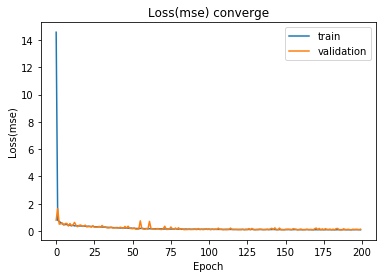

In [23]:
model, result = create_model(X_train, y_train)

In [24]:
pred = model.predict(X_test)

print('\n')
print(pred[:10])
print('\n')
print(y_test[:10])

print("Mean absolute error (MAE): %f" % skm.mean_absolute_error(y_test,pred))
print("Mean squared error (MSE):  %f" % skm.mean_squared_error(y_test,pred))
print("R square (R^2):            %f" % skm.r2_score(y_test,pred))



[[ 8.978751  ]
 [ 0.08024114]
 [ 0.2089924 ]
 [ 0.86440647]
 [ 1.5359844 ]
 [ 5.265168  ]
 [ 0.1419996 ]
 [ 0.14463499]
 [ 1.0365124 ]
 [14.84845   ]]


[[ 9.05]
 [ 0.06]
 [ 0.15]
 [ 0.76]
 [ 1.54]
 [ 5.2 ]
 [ 0.05]
 [ 0.17]
 [ 1.03]
 [14.5 ]]
Mean absolute error (MAE): 0.182388
Mean squared error (MSE):  0.126627
R square (R^2):            0.999105


In [25]:
pred = pred.flatten()
y_test = y_test.flatten()

In [26]:
# y_pred = sc_y.inverse_transform(pred)
# y_actu = sc_y.inverse_transform(y_test)
# print('actual value:\n', y_actu[:10])
# print('actual predicted value:\n', y_pred[:10])

# print("Mean absolute error (MAE): %f" % skm.mean_absolute_error(y_actu,y_pred))
# print("Mean squared error (MSE):  %f" % skm.mean_squared_error(y_actu,y_pred))
# print("R square (R^2):            %f" % skm.r2_score(y_actu,y_pred))

In [27]:
model.save('model4_1_at.h5')

# In the Money

In [34]:
def create_model(X, y):#neurons_1=1,learn_rate=0.01):
    
    model = Sequential()
    
    es = EarlyStopping(monitor='val_loss', min_delta=0, patience=25, verbose=0, mode='auto')
    
    model.add(Dense(50, input_shape = (7,), activation = 'relu'))
    model.add(Dense(100, activation = 'relu'))
    model.add(Dense(300, activation = 'elu'))
    model.add(Dense(500, activation = 'relu'))
    model.add(Dense(100, activation = 'elu'))
    model.add(Dense(1, activation = 'linear'))
    
    optimizer = Adam()
    model.compile(optimizer = optimizer, loss = 'mse', metrics = ['mae',r_square,mpe])
    
    result = model.fit(X,y, epochs = 200, batch_size = 1024, validation_split = 0.1, verbose = 1, callbacks = [es])
    
    # plot training curve for rmse
    plt.plot(result.history['loss'])
    plt.plot(result.history['val_loss'])
    plt.title('Loss(mse) converge')
    plt.ylabel('Loss(mse)')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()
    
    return model, result

In [35]:
modelin, resultin = create_model(X_traini, y_traini)

Train on 432000 samples, validate on 48000 samples
Epoch 1/200
432000/432000 [==============================] - 8s 19us/step - loss: nan - mean_absolute_error: nan - r_square: nan - mpe: inf - val_loss: nan - val_mean_absolute_error: nan - val_r_square: nan - val_mpe: inf
Epoch 2/200
 10240/432000 [..............................] - ETA: 7s - loss: nan - mean_absolute_error: nan - r_square: nan - mpe: inf

C:\Users\wangmi94\AppData\Roaming\Python\Python36\site-packages\keras\callbacks.py:816: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current - self.min_delta, self.best):


122880/432000 [=======>......................] - ETA: 5s - loss: nan - mean_absolute_error: nan - r_square: nan - mpe: inf

KeyboardInterrupt: 

In [18]:
predin = modelin.predict(X_testi)

print('\n')
print(predin[:10])
print('\n')
print(y_testi[:10])

print("Mean absolute error (MAE): %f" % skm.mean_absolute_error(y_testi,predin))
print("Mean squared error (MSE):  %f" % skm.mean_squared_error(y_testi,predin))
print("R square (R^2):            %f" % skm.r2_score(y_testi,predin))



[[10.560386 ]
 [ 3.5515652]
 [ 5.3943434]
 [ 7.5527973]
 [10.136771 ]
 [ 1.1011901]
 [10.474825 ]
 [64.36874  ]
 [ 0.8469987]
 [12.215063 ]]


[[11.45]
 [ 3.95]
 [ 5.1 ]
 [ 7.5 ]
 [ 9.45]
 [ 1.1 ]
 [11.1 ]
 [64.3 ]
 [ 1.02]
 [12.5 ]]
Mean absolute error (MAE): 0.160371
Mean squared error (MSE):  0.080786
R square (R^2):            0.999442


In [44]:
predin = predin.flatten()
y_testi = y_testi.flatten()

In [19]:
# y_pred = sc_y.inverse_transform(pred)
# y_actu = sc_y.inverse_transform(y_test)
# print('actual value:\n', y_actu[:10])
# print('actual predicted value:\n', y_pred[:10])

# print("Mean absolute error (MAE): %f" % skm.mean_absolute_error(y_actu,y_pred))
# print("Mean squared error (MSE):  %f" % skm.mean_squared_error(y_actu,y_pred))
# print("R square (R^2):            %f" % skm.r2_score(y_actu,y_pred))

In [20]:
modelin.save('model4_1_in.h5')

# Out of the Money

In [29]:
modelout, resultout = create_model(X_traino, y_traino)

Train on 432000 samples, validate on 48000 samples
Epoch 1/200
432000/432000 [==============================] - 8s 19us/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 2/200
 10240/432000 [..............................] - ETA: 8s - loss: nan - mean_absolute_error: nan

C:\Users\wangmi94\AppData\Roaming\Python\Python36\site-packages\keras\callbacks.py:816: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current - self.min_delta, self.best):


334848/432000 [======================>.......] - ETA: 1s - loss: nan - mean_absolute_error: nan

KeyboardInterrupt: 

In [18]:
predo = modelout.predict(X_testo)

print('\n')
print(predo[:10])
print('\n')
print(y_testo[:10])

print("Mean absolute error (MAE): %f" % skm.mean_absolute_error(y_testo,predo))
print("Mean squared error (MSE):  %f" % skm.mean_squared_error(y_testo,predo))
print("R square (R^2):            %f" % skm.r2_score(y_testo,predo))



[[10.560386 ]
 [ 3.5515652]
 [ 5.3943434]
 [ 7.5527973]
 [10.136771 ]
 [ 1.1011901]
 [10.474825 ]
 [64.36874  ]
 [ 0.8469987]
 [12.215063 ]]


[[11.45]
 [ 3.95]
 [ 5.1 ]
 [ 7.5 ]
 [ 9.45]
 [ 1.1 ]
 [11.1 ]
 [64.3 ]
 [ 1.02]
 [12.5 ]]
Mean absolute error (MAE): 0.160371
Mean squared error (MSE):  0.080786
R square (R^2):            0.999442


In [44]:
predo = predo.flatten()
y_testo = y_testo.flatten()

In [19]:
# y_pred = sc_y.inverse_transform(pred)
# y_actu = sc_y.inverse_transform(y_test)
# print('actual value:\n', y_actu[:10])
# print('actual predicted value:\n', y_pred[:10])

# print("Mean absolute error (MAE): %f" % skm.mean_absolute_error(y_actu,y_pred))
# print("Mean squared error (MSE):  %f" % skm.mean_squared_error(y_actu,y_pred))
# print("R square (R^2):            %f" % skm.r2_score(y_actu,y_pred))

In [20]:
model.save('model4_1_out.h5')

## Random Forest Model

In [24]:
def data_2(s_df):
    
    y = s_df['best_offer'].values
    X = s_df[['strike_price', 'underlying_price', 'maturity', 'impl_volatility', 'cp_flag_C', 'cp_flag_P', 'interest_rate', 'intrinsic']]
    
    return X, y

In [27]:
X, y = data_2(sample_df.sample(n=500000))

In [29]:
def rfr_model(X, y):
    regr = RandomForestRegressor(max_depth=2, random_state=0, n_estimators=100)
    
    y = y.reshape(-1,1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    sc_X = StandardScaler()
    X_scale = sc_X.fit_transform(X_train)
    X_scale_test = sc_X.fit_transform(X_test)

    sc_y = StandardScaler()

    y_scale = sc_y.fit_transform(y_train)
    y_scale_test = sc_y.fit_transform(y_test)
    
    regr.fit(X_scale, y_scale)
    
    results = regr.predict(X_scale_test)
    
    print('y_scale data:\n', y_scale_test[:10])
    print('scaled y_predition:\n', results[:10])
    print('\n')
    
    y_pred = sc_y.inverse_transform(results)
    print('actual value:\n', y_test[:10])
    print('actual predicted value:\n', y_pred[:10])
    
    
    print("Mean absolute error (MAE):      %f" % skm.mean_absolute_error(y_test,results))
    print("Mean squared error (MSE):       %f" % skm.mean_squared_error(y_test,results))
    
    return regr

In [30]:
rfr = rfr_model(X,y)

C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


y_scale data:
 [[-0.35380612]
 [-0.57513321]
 [-0.51980144]
 [-0.10481315]
 [-0.57680993]
 [-0.53489192]
 [-0.54662897]
 [-0.53489192]
 [-0.05870334]
 [-0.54830569]]
scaled y_predition:
 [-0.41988567 -0.41988567 -0.41988567 -0.41988567 -0.41988567 -0.41988567
 -0.41988567 -0.41988567 -0.41988567 -0.41988567]


actual value:
 [[2.68]
 [0.04]
 [0.7 ]
 [5.65]
 [0.02]
 [0.52]
 [0.38]
 [0.52]
 [6.2 ]
 [0.36]]
actual predicted value:
 [1.8918001 1.8918001 1.8918001 1.8918001 1.8918001 1.8918001 1.8918001
 1.8918001 1.8918001 1.8918001]
Mean absolute error (MAE):      6.898769
Mean squared error (MSE):       169.867897


## Reference: 
&emsp;&emsp;What does 'Accuracy' mean in Regression? https://github.com/keras-team/keras/issues/7947 <br>
&emsp;&emsp;https://keras.io/metrics/<br>
&emsp;&emsp;Scale, Standardize, or Normalize with Scikit-Learn https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02 <br>
&emsp;&emsp;The Day my Computer Won the Nobel Prize (Neural Network Option Pricing)  https://medium.com/datadriveninvestor/the-day-my-computer-won-the-nobel-prize-neural-network-option-pricing-d29b4379f1d2 <br>